# Научно-исследовательская работа по Технологиям машинного обучения на тему Предсказательная модель заработной платы.
#Выполнил Малютин Илья ИУ5-64Б

## Поиск и выбор набора данных для построения моделей машинного обучения.

В качестве набора данных мы будем использовать набор данных
для бинарной классификации людей имеющих зарплату более 50000 - https://archive.ics.uci.edu/dataset/2/adult

Эта задача является очень актуальной для банковской сферы в ситуациях, когда необходимо понять можно ли конкретному человеку выдать кредит или нет.

Датасет состоит из трех файлов:
- adult.data - обучающая выборка
- adult.test - тестовая выборка (50% от размера обучающей выборки)

Каждый файл содержит следующие колонки:
- age - Возраст.
- workclass - Класс трудоустроенности.
- fnlwgt - Весовой параметр.
- education - Образование.
- education-num - Уровень образование (вычисляемый относительно параметра education).
- marital-status - "Брачное" положение
- occupation - Профессия.
- relationship - Семейной положение.
- race - Расовая принадлежность
- sex - Пол
- capital-gain - Прирост капитала
- capital-loss - Потеря капитала
- hours-per-week - Количество рабочих часов в неделе
- native-country - Страна происхождения
- income - Целевой бинарный признак - >50K, <=50K

В рассматриваемом примере будем решать задачу классификации:
- Для решения **задачи классификации** в качестве целевого признака будем использовать "income". Поскольку признак содержит только значения >50K, <=50K, то это задача бинарной классификации.

### ВАЖНО!!! В первую строку файлов датасета были добавлены названия столбцов, так как в исходном датасете они отсутствуют
age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, income

### Импорт библиотек
Импортируем библиотеки с помощью команды import. Как правило, все команды import размещают в первых ячейках ноутбука.

In [ ]:
#Вспомогательные функции для кросс валидации
# !/usr/bin/env python

import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import pprint
from scipy import stats
from IPython.display import display

def plot_grid_search(clf):
    """Plot as many graphs as parameters are in the grid search results.

    Each graph has the values of each parameter in the X axis and the Score in the Y axis.

    Parameters
    ----------
    clf: estimator object result of a GridSearchCV
        This object contains all the information of the cross validated results for all the parameters combinations.
    """
    # Convert the cross validated results in a DataFrame ordered by `rank_test_score` and `mean_fit_time`.
    # As it is frequent to have more than one combination with the same max score,
    # the one with the least mean fit time SHALL appear first.
    cv_results = pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score', 'mean_fit_time'])

    # Get parameters
    parameters = cv_results['params'][0].keys()

    # Calculate the number of rows and columns necessary
    rows = -(-len(parameters) // 2)
    columns = min(len(parameters), 2)
    # Create the subplot
    fig = make_subplots(rows=rows, cols=columns)
    # Initialize row and column indexes
    row = 1
    column = 1

    # For each of the parameters
    for parameter in parameters:

        # As all the graphs have the same traces, and by default all traces are shown in the legend,
        # the description appears multiple times. Then, only show legend of the first graph.
        if row == 1 and column == 1:
            show_legend = True
        else:
            show_legend = False

        # Mean test score
        mean_test_score = cv_results[cv_results['rank_test_score'] != 1]
        fig.add_trace(go.Scatter(
            name='Mean test score',
            x=mean_test_score['param_' + parameter],
            y=mean_test_score['mean_test_score'],
            mode='markers',
            marker=dict(size=mean_test_score['mean_fit_time'],
                        color='SteelBlue',
                        sizeref=2. * cv_results['mean_fit_time'].max() / (40. ** 2),
                        sizemin=4,
                        sizemode='area'),
            text=mean_test_score['params'].apply(
                lambda x: pprint.pformat(x, width=-1).replace('{', '').replace('}', '').replace('\n', '<br />')),
            showlegend=show_legend),
            row=row,
            col=column)

        # Best estimators
        rank_1 = cv_results[cv_results['rank_test_score'] == 1]
        fig.add_trace(go.Scatter(
            name='Best estimators',
            x=rank_1['param_' + parameter],
            y=rank_1['mean_test_score'],
            mode='markers',
            marker=dict(size=rank_1['mean_fit_time'],
                        color='Crimson',
                        sizeref=2. * cv_results['mean_fit_time'].max() / (40. ** 2),
                        sizemin=4,
                        sizemode='area'),
            text=rank_1['params'].apply(str),
            showlegend=show_legend),
            row=row,
            col=column)

        fig.update_xaxes(title_text=parameter, row=row, col=column)
        fig.update_yaxes(title_text='Score', row=row, col=column)

        # Check the linearity of the series
        # Only for numeric series
        if pd.to_numeric(cv_results['param_' + parameter], errors='coerce').notnull().all():
            x_values = cv_results['param_' + parameter].sort_values().unique().tolist()
            r = stats.linregress(x_values, range(0, len(x_values))).rvalue
            # If not so linear, then represent the data as logarithmic
            if r < 0.86:
                fig.update_xaxes(type='log', row=row, col=column)

        # Increment the row and column indexes
        column += 1
        if column > columns:
            column = 1
            row += 1

            # Show first the best estimators
    fig.update_layout(legend=dict(traceorder='reversed'),
                      width=columns * 360 + 100,
                      height=rows * 360,
                      title='Best score: {:.6f} with {}'.format(cv_results['mean_test_score'].iloc[0],
                                                                str(cv_results['params'].iloc[0]).replace('{',
                                                                                                          '').replace(
                                                                    '}', '')),
                      hovermode='closest',
                      template='none')
    fig.show()


def table_grid_search(clf, all_columns=False, all_ranks=False, save=True):
    """Show tables with the grid search results.

    Parameters
    ----------
    clf: estimator object result of a GridSearchCV
        This object contains all the information of the cross validated results for all the parameters combinations.

    all_columns: boolean, default: False
        If true all columns are returned. If false, the following columns are dropped:

        - params. As each parameter has a column with the value.
        - std_*. Standard deviations.
        - split*. Split scores.

    all_ranks: boolean, default: False
        If true all ranks are returned. If false, only the rows with rank equal to 1 are returned.

    save: boolean, default: True
        If true, results are saved to a CSV file.
    """
    # Convert the cross validated results in a DataFrame ordered by `rank_test_score` and `mean_fit_time`.
    # As it is frequent to have more than one combination with the same max score,
    # the one with the least mean fit time SHALL appear first.
    cv_results = pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score', 'mean_fit_time'])

    # Reorder
    columns = cv_results.columns.tolist()
    # rank_test_score first, mean_test_score second and std_test_score third
    columns = columns[-1:] + columns[-3:-1] + columns[:-3]
    cv_results = cv_results[columns]

    if save:
        cv_results.to_csv('--'.join(cv_results['params'][0].keys()) + '.csv', index=True, index_label='Id')

    # Unless all_columns are True, drop not wanted columns: params, std_* split*
    if not all_columns:
        cv_results.drop('params', axis='columns', inplace=True)
        cv_results.drop(list(cv_results.filter(regex='^std_.*')), axis='columns', inplace=True)
        cv_results.drop(list(cv_results.filter(regex='^split.*')), axis='columns', inplace=True)

    # Unless all_ranks are True, filter out those rows which have rank equal to one
    if not all_ranks:
        cv_results = cv_results[cv_results['rank_test_score'] == 1]
        cv_results.drop('rank_test_score', axis='columns', inplace=True)
        cv_results = cv_results.style.hide_index()

    display(cv_results)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, \
    r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
%matplotlib inline
sns.set(style="ticks")

### Загрузка данных

Загрузим файлы датасета в помощью библиотеки Pandas.

Не смотря на то, что файлы имеют расширение txt они представляют собой данные в формате CSV (https://ru.wikipedia.org/wiki/CSV). Часто в файлах такого формата в качестве разделителей используются символы ",", ";" или табуляция. Поэтому вызывая метод read_csv всегда стоит явно указывать разделитель данных с помощью параметра sep. Чтобы узнать какой разделитель используется в файле его рекомендуется предварительно посмотреть в любом текстовом редакторе.

In [ ]:
# Обучающая выборка
original_train = pd.read_csv(r'adult.data', delimiter=", ", engine="python")
# Тестовая выборка
original_test_1 = pd.read_csv(r'adult.test', delimiter=", ", engine="python")

In [ ]:
# Удалим дубликаты записей, если они присутствуют
train = original_train.drop_duplicates()
test_1 = original_test_1.drop_duplicates()

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

### Основные характеристики датасетов

Так как пропуски обозначены знаком "?" необходимо их заменить предварительно на null

In [ ]:
train = train.replace(to_replace='?', value=None)
test_1 = test_1.replace('?', 'None')

In [ ]:
# Первые 5 строк датасета
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
test_1.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,None,103497,Some-college,10,Never-married,None,Own-child,White,Female,0,0,30,United-States,<=50K.


In [ ]:
# Размер обучающего датасета - 32536 строк, 15 колонок
# Размер тестового датасета - 16275 строк, 15 колонок
train.shape, test_1.shape,

((32537, 15), (16276, 15))

In [ ]:
# Список колонок
train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [ ]:
# Список колонок с типами данных
# убедимся что типы данных одинаковы в обучающей и тестовых выборках
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [ ]:
test_1.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [ ]:
# Проверим наличие пустых значений
train.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64

In [ ]:
test_1.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

**Вывод. Представленный набор данных содержит пропуски**
Заменим пропуски с использованием стратегии *most_frequent*


In [ ]:
train = train.apply(lambda x: x.fillna(x.value_counts().index[0]))
test_1 = test_1.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [ ]:
train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [ ]:
test_1.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

### Построение графиков для понимания структуры данных

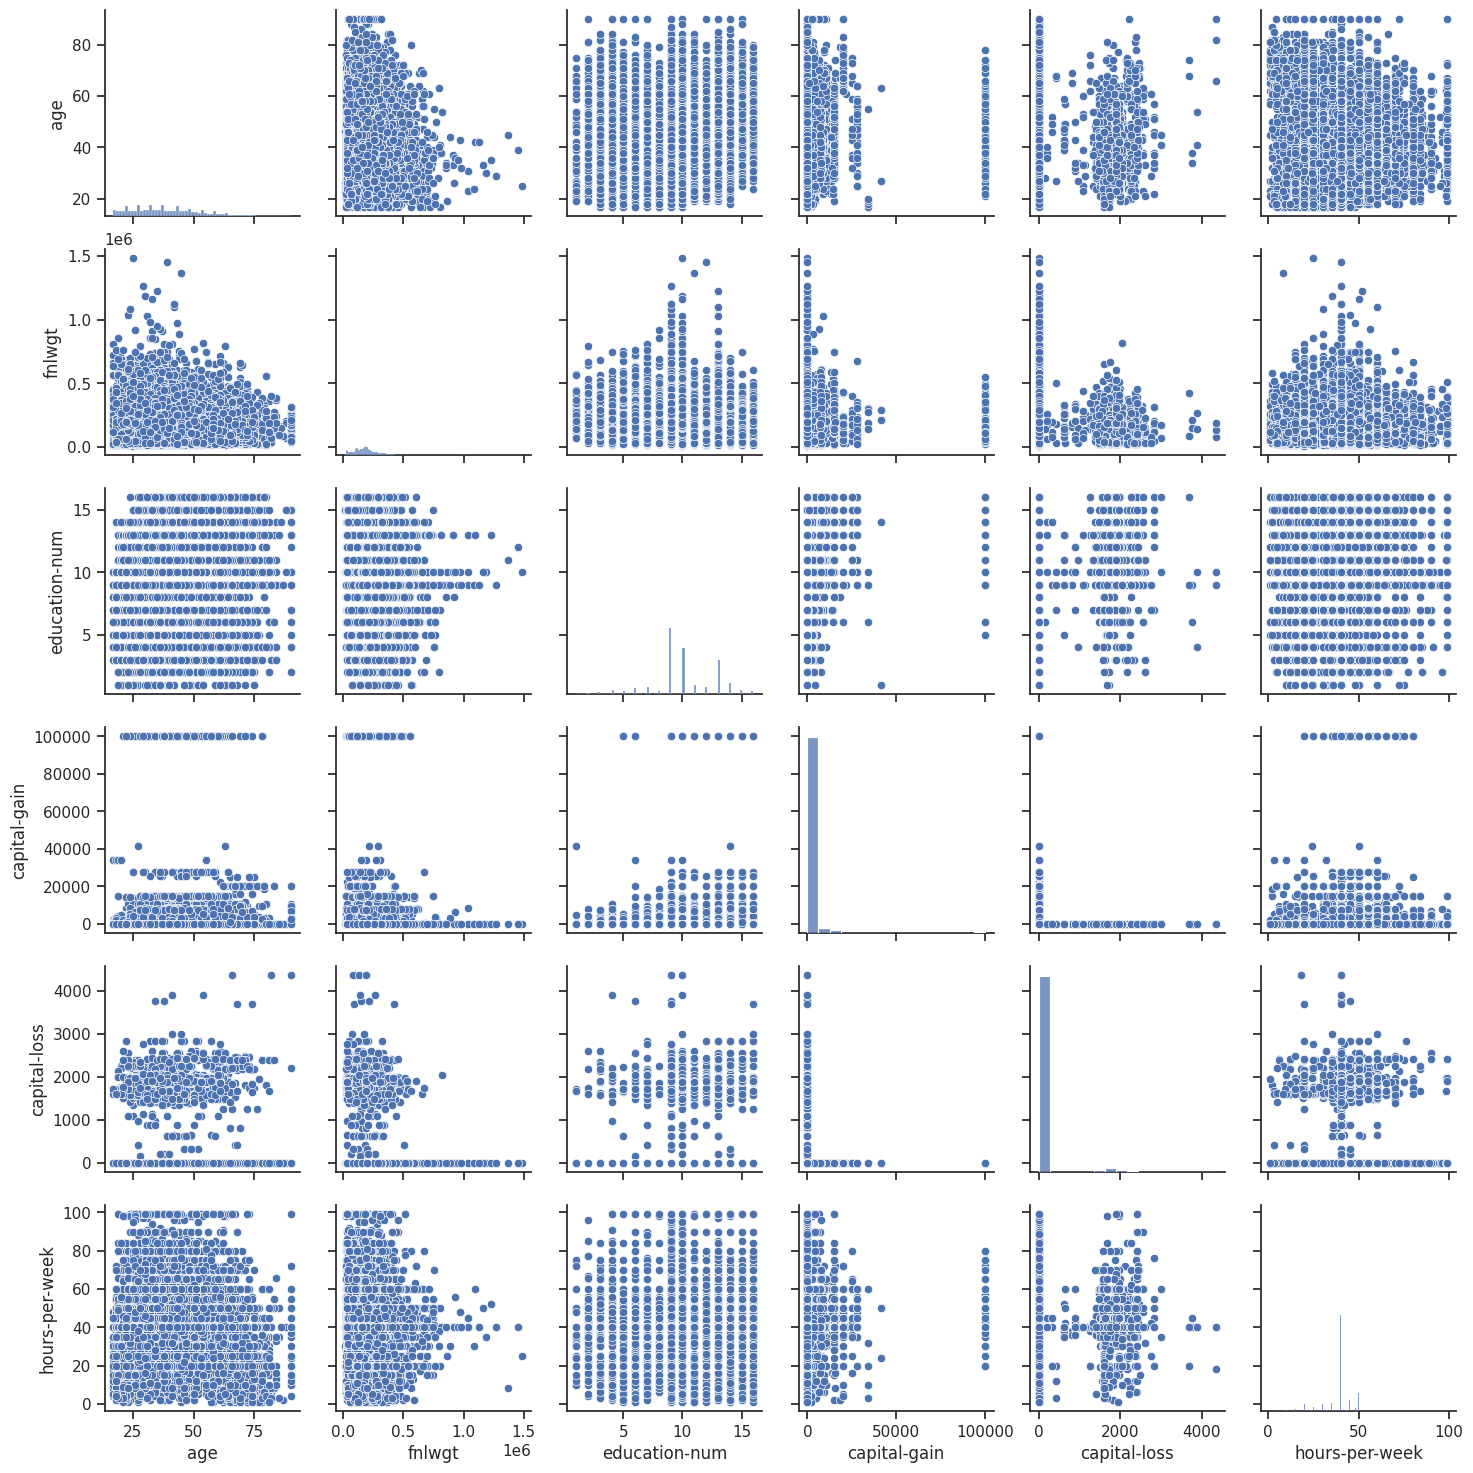

In [ ]:
# Парные диаграммы
sns.pairplot(train)

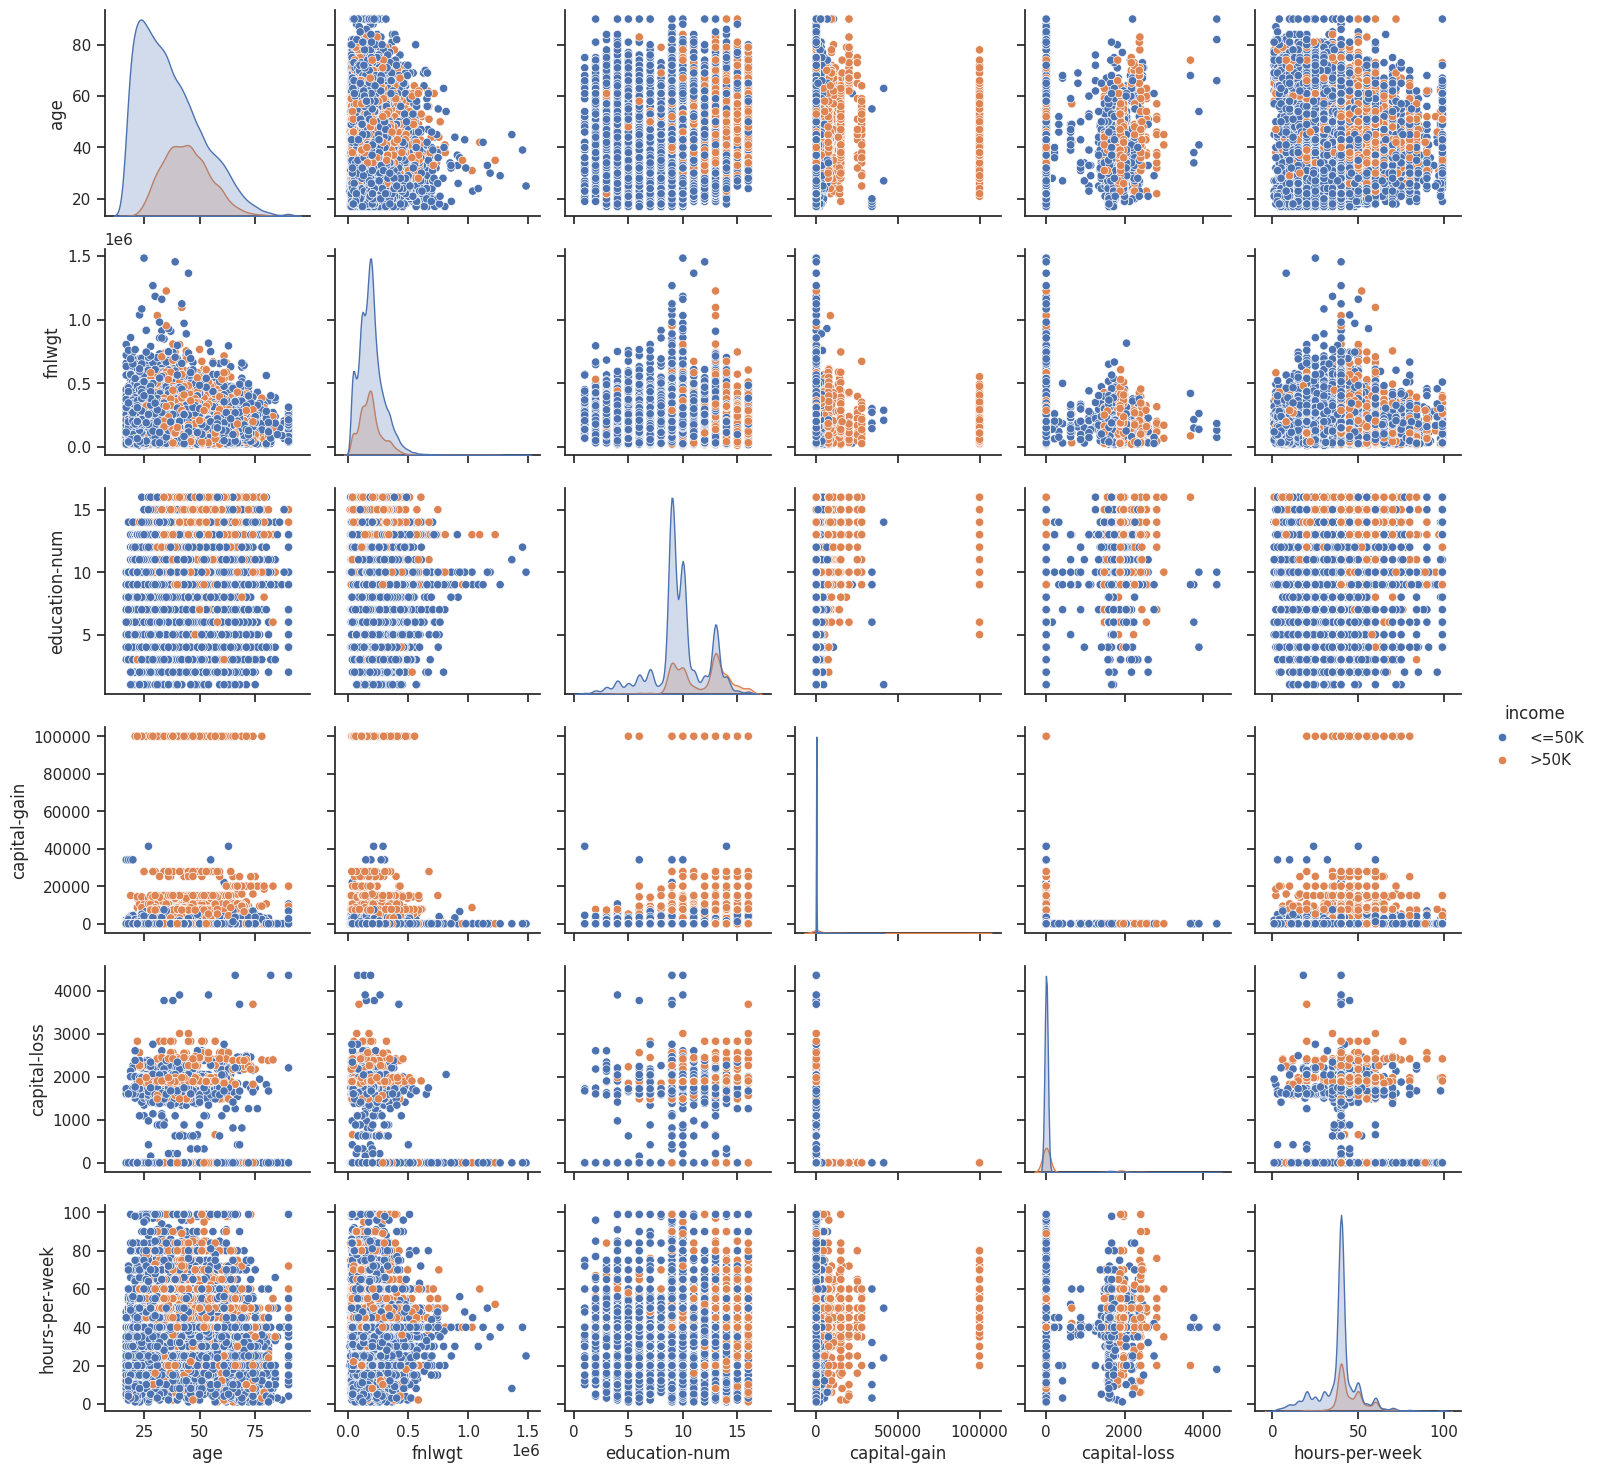

In [ ]:
sns.pairplot(train, hue="income")

In [ ]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только >50K и <=50K
train['income'].unique()

array(['<=50K', '>50K'], dtype=object)

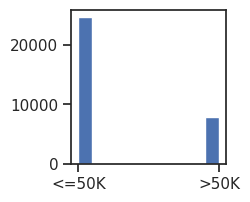

In [ ]:
# Оценим дисбаланс классов для Occupancy
fig, ax = plt.subplots(figsize=(2, 2))
plt.hist(train['income'])
plt.show()

In [ ]:
train['income'].value_counts()

income
<=50K    24698
>50K      7839
Name: count, dtype: int64

In [ ]:
# посчитаем дисбаланс классов
total = train.shape[0]
class_0, class_1 = train['income'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4) * 100, round(class_1 / total, 4) * 100))

Класс 0 составляет 75.91%, а класс 1 составляет 24.09%.


**Вывод. Дисбаланс классов присутствует, но является приемлемым.**

In [ ]:
train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

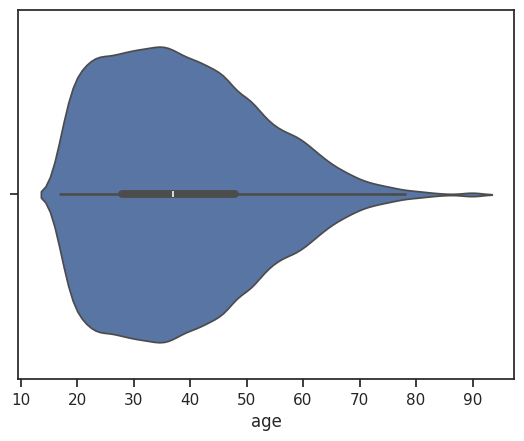

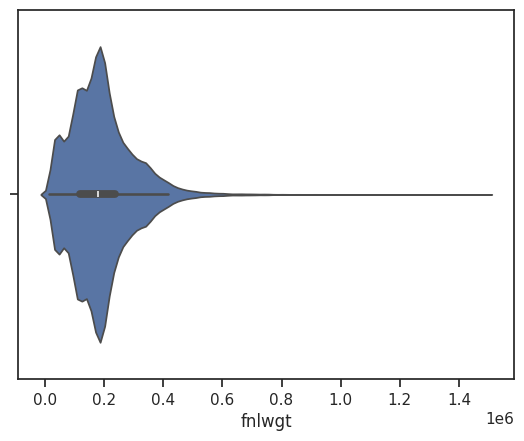

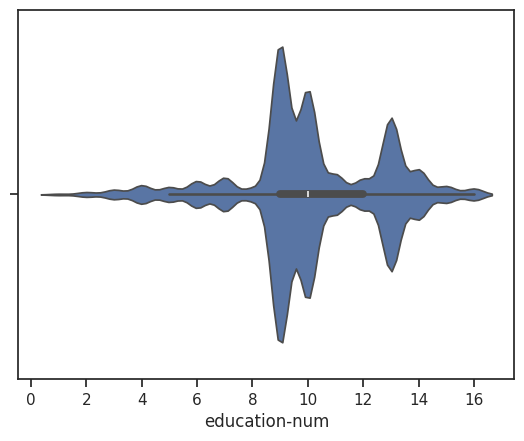

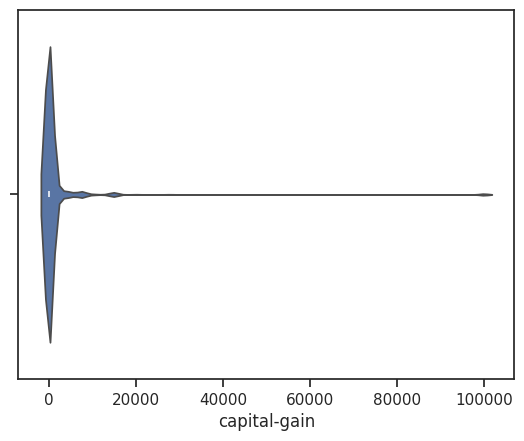

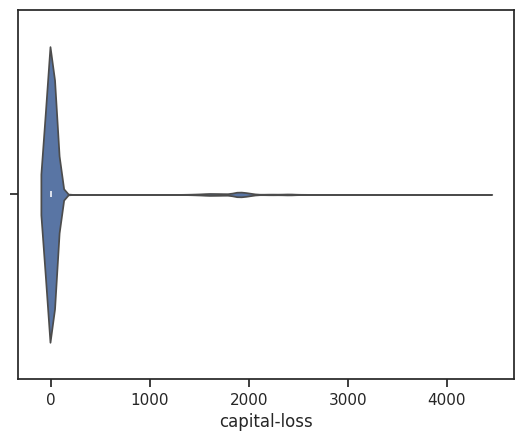

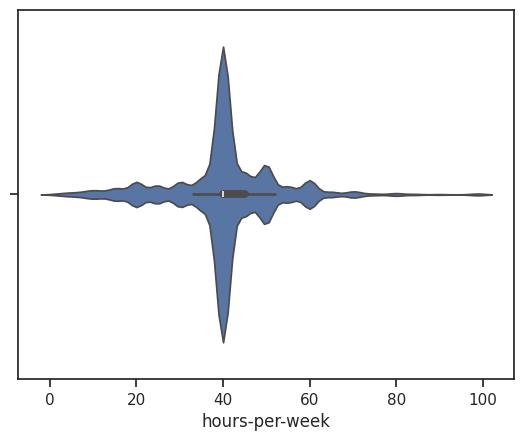

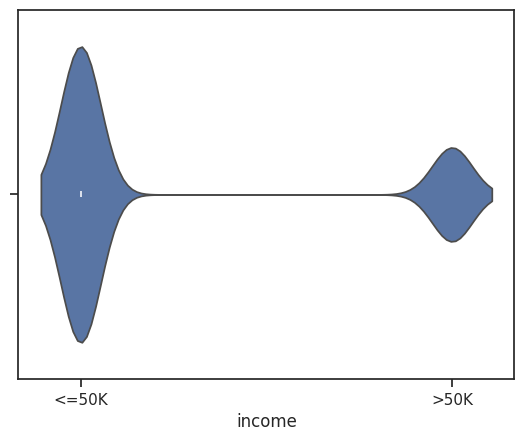

In [ ]:
# Скрипичные диаграммы для числовых колонок
for col in ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']:
    sns.violinplot(x=train[col])
    plt.show()

## Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [ ]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

Для построения моделей будем использовать все признаки.

Категориальные признаки присутствуют, необходимо их закодировать.

Вспомогательные признаки для улучшения качества моделей в данном примере мы строить не будем.

Выполним масштабирование данных. Для этого необходимо объединить обучающую и тестовые выборки.

## Кодирование категориальных признаков

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['workclass'] = le.fit_transform(train['workclass'])
train['education'] = le.fit_transform(train['education'])
train['marital-status'] = le.fit_transform(train['marital-status'])
train['occupation'] = le.fit_transform(train['occupation'])
train['relationship'] = le.fit_transform(train['relationship'])
train['race'] = le.fit_transform(train['race'])
train['sex'] = le.fit_transform(train['sex'])
train['native-country'] = le.fit_transform(train['native-country'])
train['income'] = le.fit_transform(train['income'])

test_1['workclass'] = le.fit_transform(test_1['workclass'])
test_1['education'] = le.fit_transform(test_1['education'])
test_1['marital-status'] = le.fit_transform(test_1['marital-status'])
test_1['occupation'] = le.fit_transform(test_1['occupation'])
test_1['relationship'] = le.fit_transform(test_1['relationship'])
test_1['race'] = le.fit_transform(test_1['race'])
test_1['sex'] = le.fit_transform(test_1['sex'])
test_1['native-country'] = le.fit_transform(test_1['native-country'])
test_1['income'] = le.fit_transform(test_1['income'])

train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [ ]:
# Создадим вспомогательные колонки,
# чтобы наборы данных можно было разделить.
train['dataset'] = 'TRAIN'
test_1['dataset'] = 'TEST1'

In [ ]:
# Колонки для объединения
join_cols = ['age', 'workclass', 'education', 'fnlwgt',
             'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain',
             'capital-loss',
             'hours-per-week', 'native-country', 'income', 'dataset']

In [ ]:
data_all = pd.concat([train[join_cols], test_1[join_cols]])

In [ ]:
# Проверим корректность объединения
assert data_all.shape[0] == train.shape[0] + test_1.shape[0]

In [ ]:
data_all.head()

,age,workclass,education,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,dataset
0,39,6,9,77516,13,4,0,1,4,1,2174,0,40,38,0,TRAIN
1,50,5,9,83311,13,2,3,0,4,1,0,0,13,38,0,TRAIN
2,38,3,11,215646,9,0,5,1,4,1,0,0,40,38,0,TRAIN
3,53,3,1,234721,7,2,5,0,2,1,0,0,40,38,0,TRAIN
4,28,3,9,338409,13,2,9,5,2,0,0,0,40,4,0,TRAIN


In [ ]:
# Числовые колонки для масштабирования
scale_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']

In [ ]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_all[scale_cols])

In [ ]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data_all[new_col_name] = sc1_data[:, i]

In [ ]:
data_all.head()

,age,workclass,education,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,...,native-country,income,dataset,age_scaled,fnlwgt_scaled,education-num_scaled,capital-gain_scaled,capital-loss_scaled,hours-per-week_scaled,income_scaled
0,39,6,9,77516,13,4,0,1,4,1,...,38,0,TRAIN,0.301370,0.044131,0.800000,0.02174,0.0,0.397959,0.0
1,50,5,9,83311,13,2,3,0,4,1,...,38,0,TRAIN,0.452055,0.048052,0.800000,0.00000,0.0,0.122449,0.0
2,38,3,11,215646,9,0,5,1,4,1,...,38,0,TRAIN,0.287671,0.137581,0.533333,0.00000,0.0,0.397959,0.0
3,53,3,1,234721,7,2,5,0,2,1,...,38,0,TRAIN,0.493151,0.150486,0.400000,0.00000,0.0,0.397959,0.0
4,28,3,9,338409,13,2,9,5,2,0,...,4,0,TRAIN,0.150685,0.220635,0.800000,0.00000,0.0,0.397959,0.0


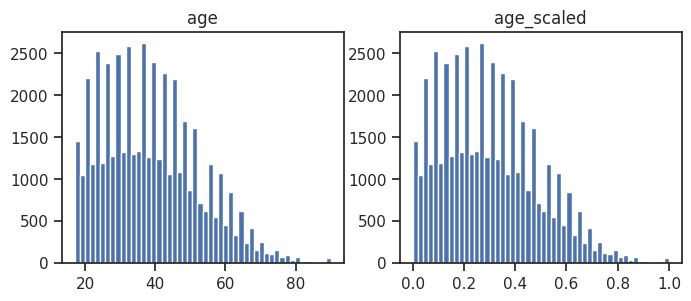

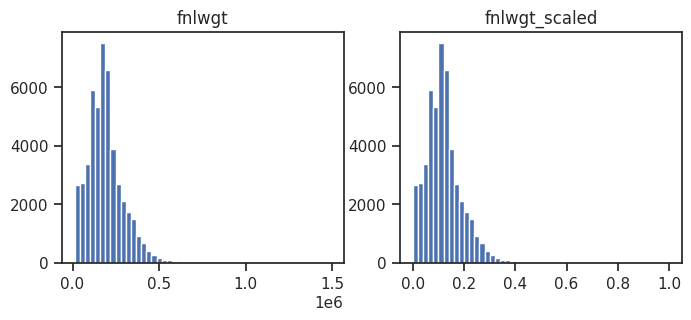

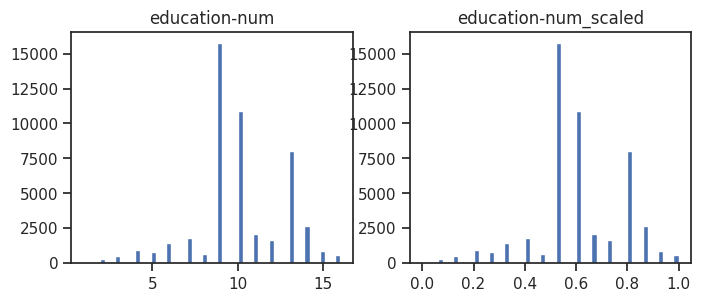

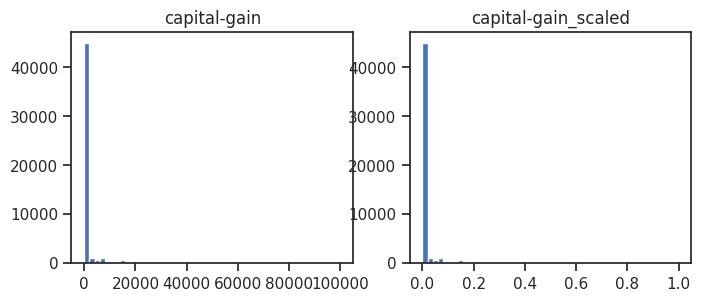

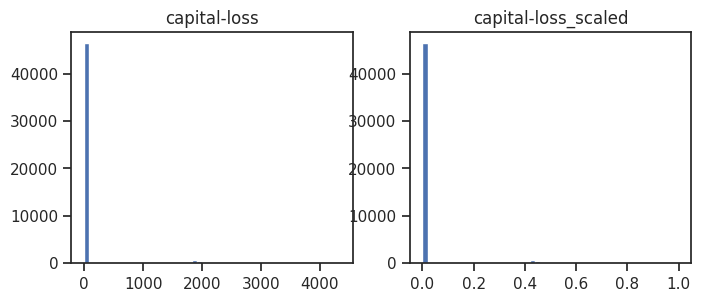

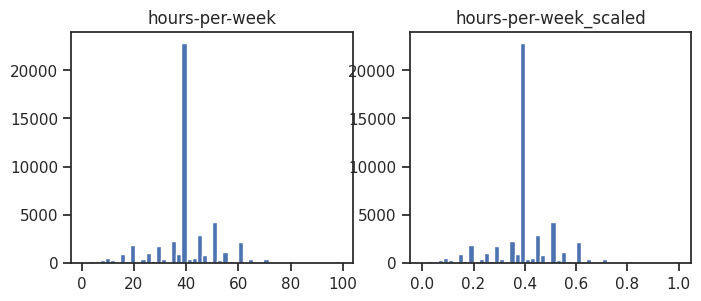

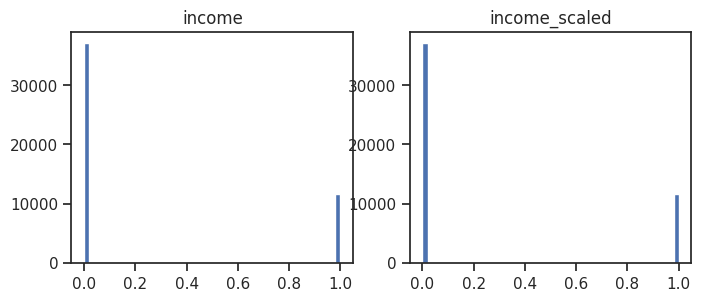

In [ ]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].hist(data_all[col], 50)
    ax[1].hist(data_all[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

In [ ]:
# Воспользуемся наличием тестовых выборок,
# включив их в корреляционную матрицу
corr_cols_1 = scale_cols + ['income']
corr_cols_1

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'income',
 'income']

In [ ]:
scale_cols_postfix = [x + '_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['income']
corr_cols_2

['age_scaled',
 'fnlwgt_scaled',
 'education-num_scaled',
 'capital-gain_scaled',
 'capital-loss_scaled',
 'hours-per-week_scaled',
 'income_scaled',
 'income']

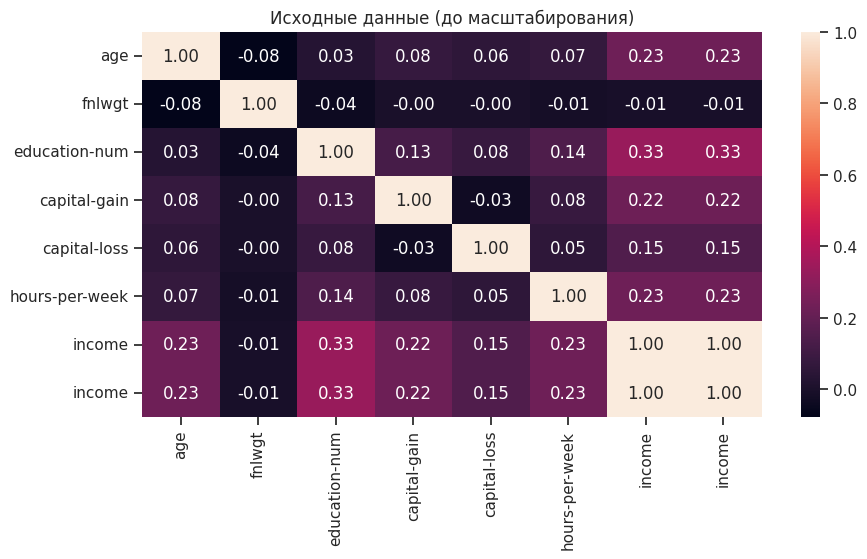

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(data_all[corr_cols_1].corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

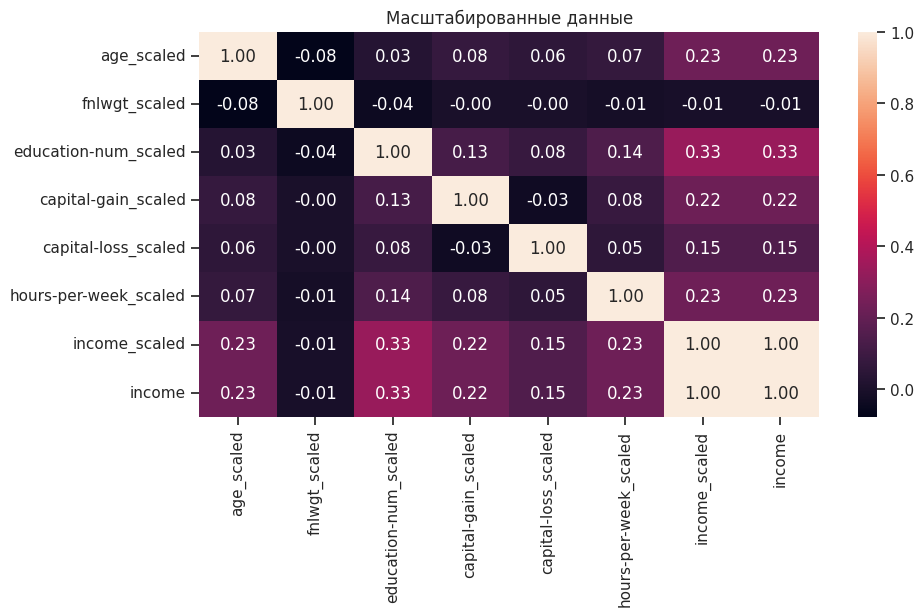

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(data_all[corr_cols_2].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

- Корреляционные матрицы для исходных и масштабированных данных совпадают.
- Целевой признак классификации "income" наиболее сильно коррелирует с Классом Образования (0.33), возрастом (0.23) и временем работы в неделю газа (0.23) и потерей/получением капитала(0,22 и 0,15 соответственно). Эти признаки обязательно следует оставить в модели классификации.
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком.  На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.

## Выбор метрик для последующей оценки качества моделей.

### В качестве метрик для решения задачи классификации  будем использовать:

Метрики, формируемые на основе матрицы ошибок:

#### Метрика precision:

Можно переводить как точность, но такой перевод совпадает с переводом метрики "accuracy".

$precision = \frac{TP}{TP+FP}$

Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

Используется функция [precision_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

#### Метрика recall (полнота):

$recall = \frac{TP}{TP+FN}$

Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.

Используется функция [recall_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

#### Метрика $F_1$-мера

Для того, чтобы объединить precision и recall в единую метрику используется $F_\beta$-мера, которая вычисляется как среднее гармоническое от precision и recall:

$F_\beta = (1+\beta^2) \cdot \frac{precision \cdot recall}{precision + recall}$

где $\beta$ определяет вес точности в метрике.

На практике чаще всего используют вариант F1-меры (которую часто называют F-мерой) при $\beta=1$:

$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$

Для вычисления используется функция [f1_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

#### Метрика ROC AUC

Основана на вычислении следующих характеристик:

$TPR = \frac{TP}{TP+FN}$ - True Positive Rate, откладывается по оси ординат. Совпадает с recall.

$FPR = \frac{FP}{FP+TN}$ - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.

Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации.

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

Для получения ROC AUC используется функция [roc_auc_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

### Сохранение и визуализация метрик

Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [ ]:
class MetricLogger:

    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
             'alg': pd.Series([], dtype='str'),
             'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric'] == metric) & (self.df['alg'] == alg)].index, inplace=True)
        # Добавление нового значения
        temp = [{'metric': metric, 'alg': alg, 'value': value}]
        self.df = self.df._append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric'] == metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values

    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5,
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a, b in zip(pos, array_metric):
            plt.text(0.5, a - 0.05, str(round(b, 3)), color='white')
        plt.show()

## Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.

Для задачи классификации будем использовать следующие модели:
- Логистическая регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

## Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [ ]:
# На основе масштабированных данных выделим
# обучающую и тестовую выборки с помощью фильтра
train_data_all = data_all[data_all['dataset'] == 'TRAIN']
test_data_all = data_all[data_all['dataset'] == 'TEST1']
train_data_all.shape, test_data_all.shape

((32537, 23), (16276, 23))

In [ ]:
#Вспомогательная ячейка
data_all.head()

,age,workclass,education,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,...,native-country,income,dataset,age_scaled,fnlwgt_scaled,education-num_scaled,capital-gain_scaled,capital-loss_scaled,hours-per-week_scaled,income_scaled
0,39,6,9,77516,13,4,0,1,4,1,...,38,0,TRAIN,0.301370,0.044131,0.800000,0.02174,0.0,0.397959,0.0
1,50,5,9,83311,13,2,3,0,4,1,...,38,0,TRAIN,0.452055,0.048052,0.800000,0.00000,0.0,0.122449,0.0
2,38,3,11,215646,9,0,5,1,4,1,...,38,0,TRAIN,0.287671,0.137581,0.533333,0.00000,0.0,0.397959,0.0
3,53,3,1,234721,7,2,5,0,2,1,...,38,0,TRAIN,0.493151,0.150486,0.400000,0.00000,0.0,0.397959,0.0
4,28,3,9,338409,13,2,9,5,2,0,...,4,0,TRAIN,0.150685,0.220635,0.800000,0.00000,0.0,0.397959,0.0


In [ ]:
# Признаки для задачи классификации
task_clas_cols = ['age_scaled', 'workclass', 'education', 'fnlwgt_scaled',
                  'education-num_scaled', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
                  'capital-gain_scaled', 'capital-loss_scaled',
                  'hours-per-week_scaled', 'native-country']

In [ ]:
# Выборки для задачи классификации
clas_X_train = train_data_all[task_clas_cols]
clas_X_test = test_data_all[task_clas_cols]
clas_Y_train = train_data_all['income']
clas_Y_test = test_data_all['income']
clas_X_train.shape, clas_X_test.shape, clas_Y_train.shape, clas_Y_test.shape

((32537, 14), (16276, 14), (32537,), (16276,))

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

### Решение задачи классификации

In [ ]:
# Модели
clas_models = {'LogR': LogisticRegression(max_iter=1000),
               'KNN_5': KNeighborsClassifier(n_neighbors=5),
               'SVC': SVC(probability=True),
               'Tree': DecisionTreeClassifier(),
               'RF': RandomForestClassifier(),
               'GB': GradientBoostingClassifier()}

In [ ]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [ ]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score,
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    #plt.figure()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(clas_X_train, clas_Y_train)
    # Предсказание значений
    Y_pred = model.predict(clas_X_test)
    # Предсказание вероятности класса "1" для roc auc
    Y_pred_proba_temp = model.predict_proba(clas_X_test)
    Y_pred_proba = Y_pred_proba_temp[:, 1]

    precision = precision_score(clas_Y_test.values, Y_pred)
    recall = recall_score(clas_Y_test.values, Y_pred)
    f1 = f1_score(clas_Y_test.values, Y_pred)
    roc_auc = roc_auc_score(clas_Y_test.values, Y_pred_proba)

    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    draw_roc_curve(clas_Y_test.values, Y_pred_proba, ax[0])
    ConfusionMatrixDisplay.from_estimator(model, clas_X_test, clas_Y_test.values, ax=ax[1],
                                          display_labels=['0', '1'],
                                          cmap=plt.cm.Blues, normalize='true')
    fig.suptitle(model_name)
    plt.show()

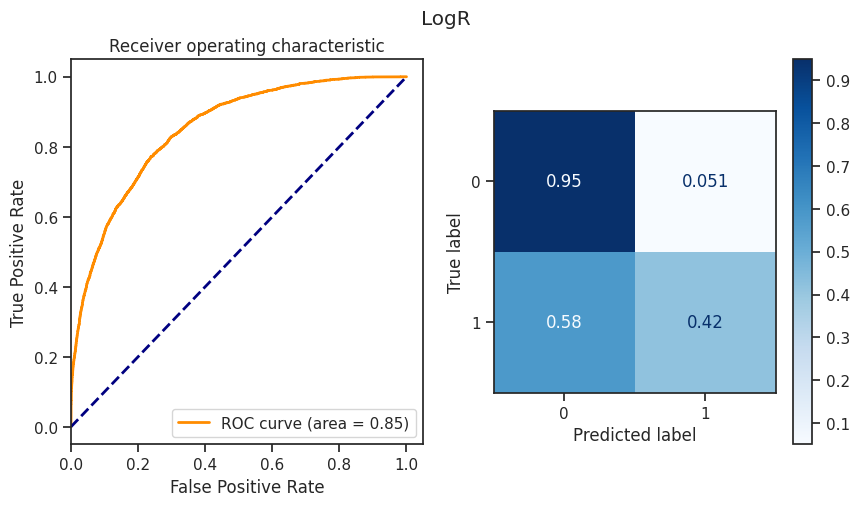

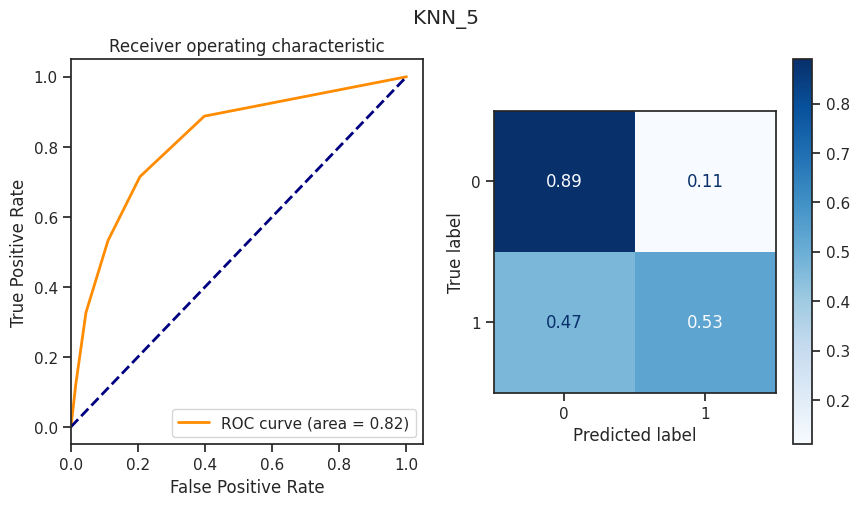

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


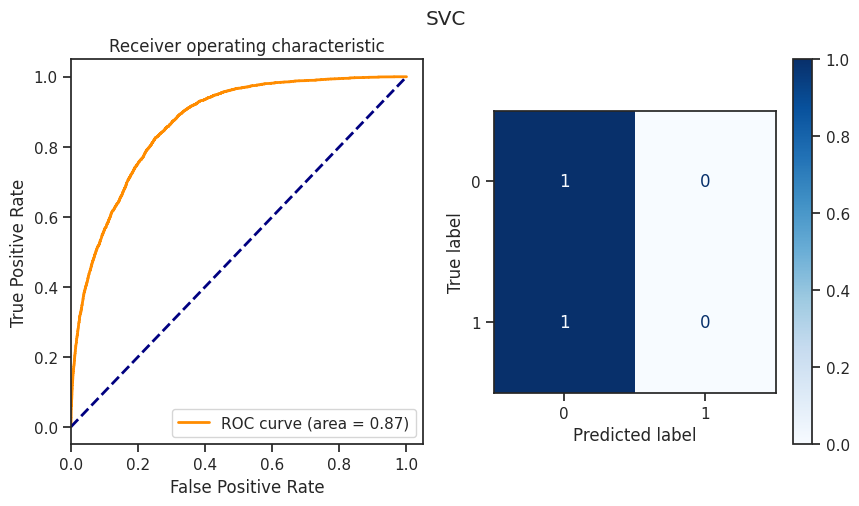

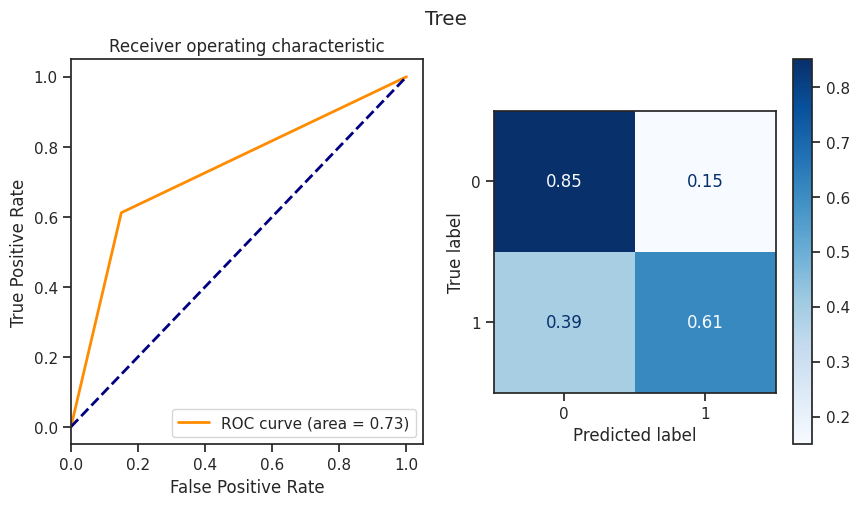

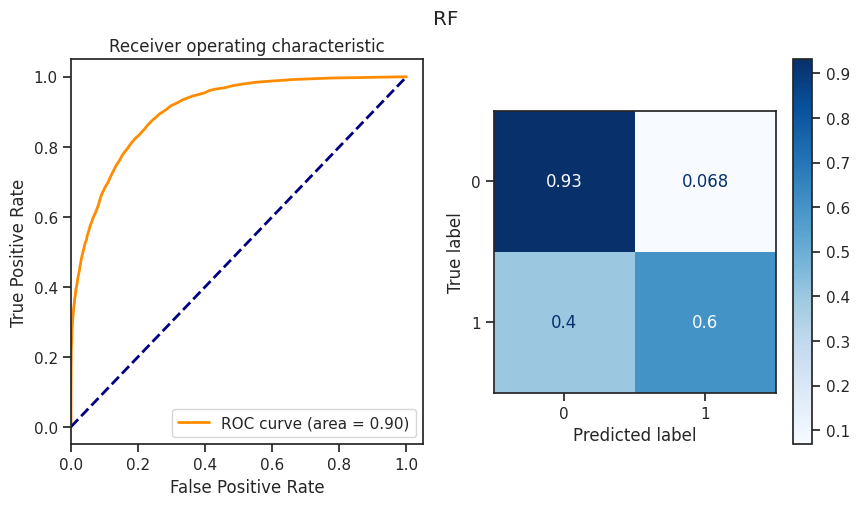

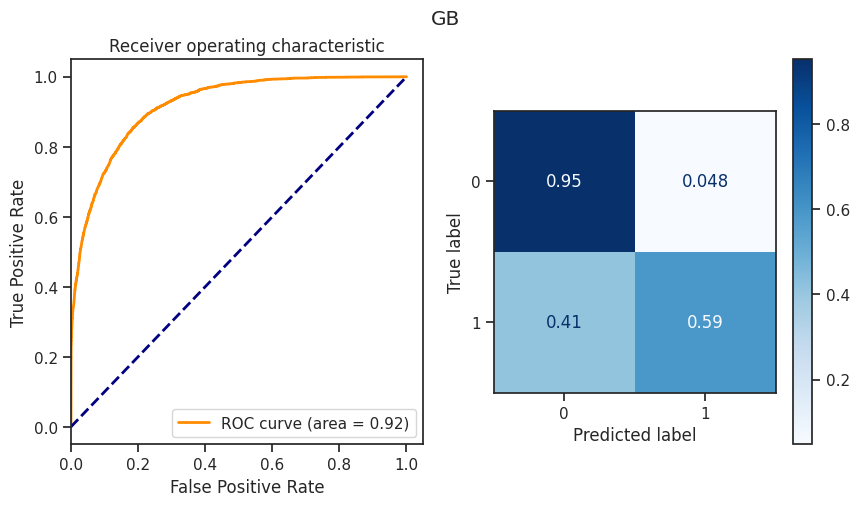

In [ ]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

## Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.

### Пример для задачи классификации

In [ ]:
clas_X_train.shape

(32537, 14)

In [ ]:
n_range_list = list(range(0, 1250, 50))
n_range_list[0] = 1

In [ ]:
n_range = np.array(n_range_list)
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([   1,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
          550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
         1100, 1150, 1200])}]

In [ ]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf_gs.fit(clas_X_train, clas_Y_train)

CPU times: user 9min 54s, sys: 15.9 s, total: 10min 10s
Wall time: 10min 11s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([   1,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200])}],
             scoring='roc_auc')

In [ ]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=50)

In [ ]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 50}

In [ ]:
clf_gs_best_params_txt = str(clf_gs.best_params_['n_neighbors'])
clf_gs_best_params_txt

'50'

In [ ]:
n_range_list = list(range(20, 50, 1))
n_range_list[0] = 1
n_range = np.array(n_range_list)
tuned_parameters = [{'n_neighbors': n_range}]

In [ ]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf_gs.fit(clas_X_train, clas_Y_train)

CPU times: user 3min 2s, sys: 222 ms, total: 3min 2s
Wall time: 3min 3s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])}],
             scoring='roc_auc')

In [ ]:
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=35)

In [ ]:
clf_gs.best_params_
clf_gs_best_params_txt = str(clf_gs.best_params_['n_neighbors'])

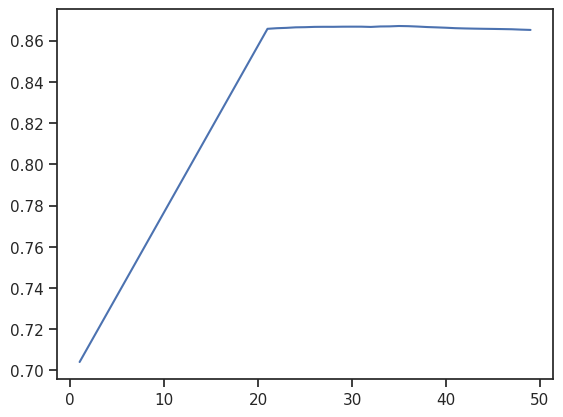

In [ ]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

# Подбор Гиперпараметра для модели Логистической Регрессии(алгоритм)

In [ ]:
#
solver = ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']
tuned_parameters = [{'solver': solver}]
tuned_parameters

[{'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']}]

In [ ]:
# from grid_search_utils import plot_grid_search, table_grid_search

clf_lr = GridSearchCV(LogisticRegression(max_iter=5000), tuned_parameters, cv=5, scoring='roc_auc')
clf_lr.fit(clas_X_train, clas_Y_train)
plot_grid_search(clf_lr)
table_grid_search(clf_lr, all_ranks=True)

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_solver
1,1,0.852173,0.646068,0.009463,newton-cg
4,2,0.852147,2.627791,0.009327,lbfgs
0,3,0.852109,0.268947,0.009057,liblinear
2,4,0.852053,8.844523,0.009157,sag
3,5,0.851929,12.229207,0.011234,saga


In [ ]:
clf_lr.best_estimator_

LogisticRegression(max_iter=5000, solver='newton-cg')

In [ ]:
clf_lr.best_params_

{'solver': 'newton-cg'}

# Подбор Гиперпараметра для модели Градиентного Спуска

In [ ]:
learning_rate = {'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]}

In [ ]:
clf_gb = GridSearchCV(GradientBoostingClassifier(), learning_rate, cv=5, scoring='roc_auc')
clf_gb.fit(clas_X_train, clas_Y_train)
plot_grid_search(clf_gb)
table_grid_search(clf_gb, all_ranks=True)

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_learning_rate
6,1,0.926052,3.607986,0.016917,0.3
7,2,0.925917,3.969074,0.018083,0.35
5,3,0.925846,4.276343,0.016594,0.25
9,4,0.925600,3.786648,0.017475,0.45
8,5,0.925481,3.733165,0.019261,0.4
10,6,0.924867,3.890271,0.019105,0.5
4,7,0.924686,3.623634,0.018101,0.2
3,8,0.919983,3.633032,0.020210,0.1
2,9,0.912939,3.874396,0.019495,0.05
1,10,0.902153,3.747804,0.020207,0.02


In [ ]:
# Лучшая модель
clf_gb.best_estimator_

GradientBoostingClassifier(learning_rate=0.3)

In [ ]:
# Лучшее значение параметров
clf_gb.best_params_

{'learning_rate': 0.3}

In [ ]:
clf_gb_best_params_txt = str(clf_gb.best_params_['learning_rate'])
clf_gb_best_params_txt

'0.3'

## Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.

### Решение задачи классификации

In [ ]:
clas_models_grid = {'KNN_5': KNeighborsClassifier(n_neighbors=5),
                    str('KNN_' + clf_gs_best_params_txt): clf_gs.best_estimator_,
                    'GB_0.1': GradientBoostingClassifier(),
                    str('GB_' + clf_gb_best_params_txt): clf_gb.best_estimator_,
                    }

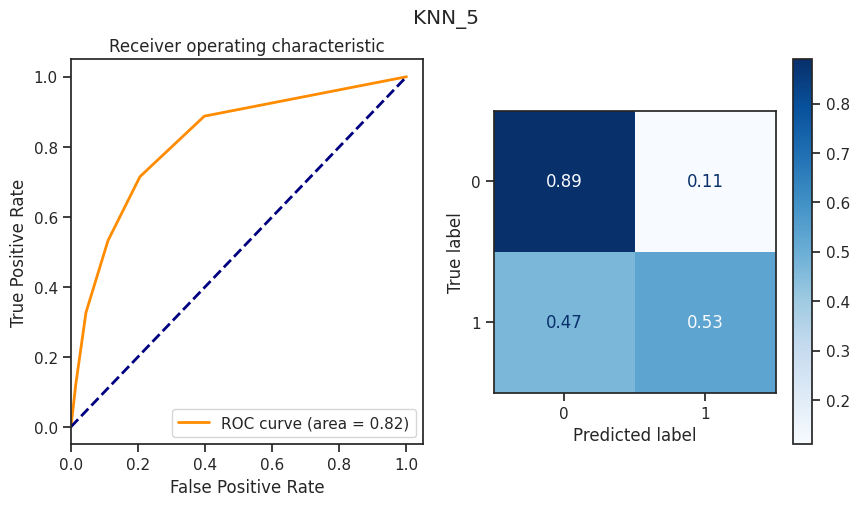

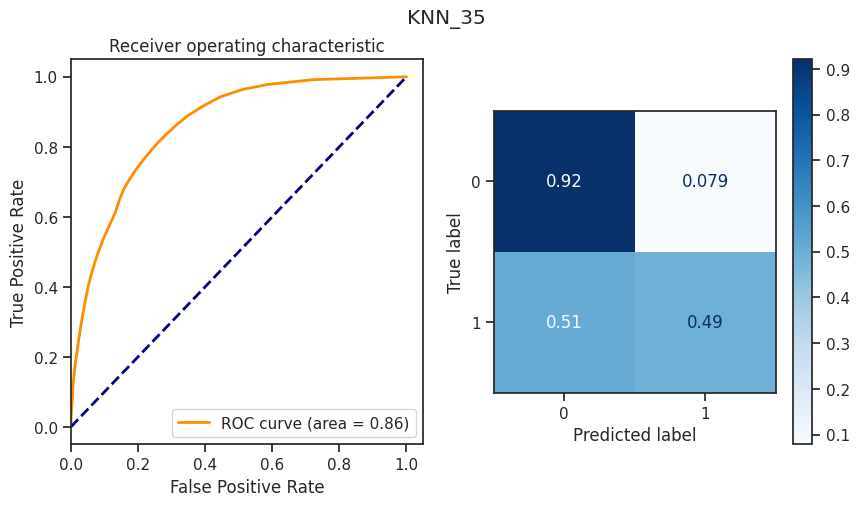

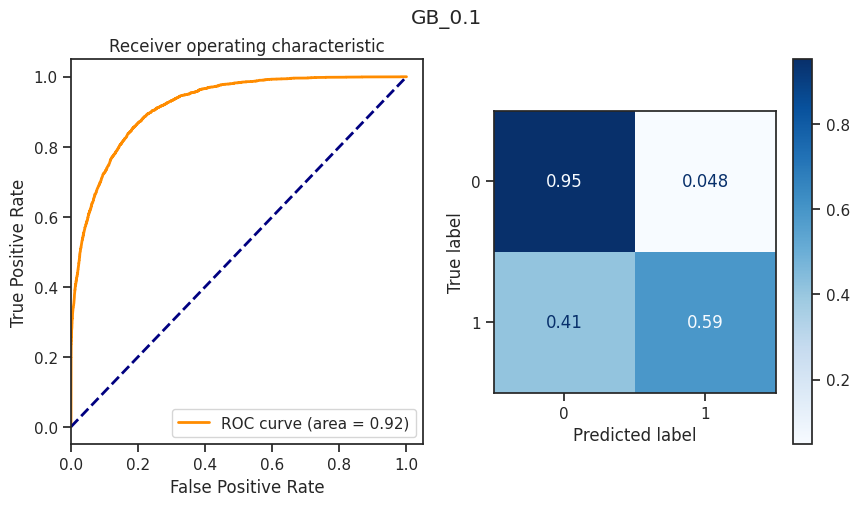

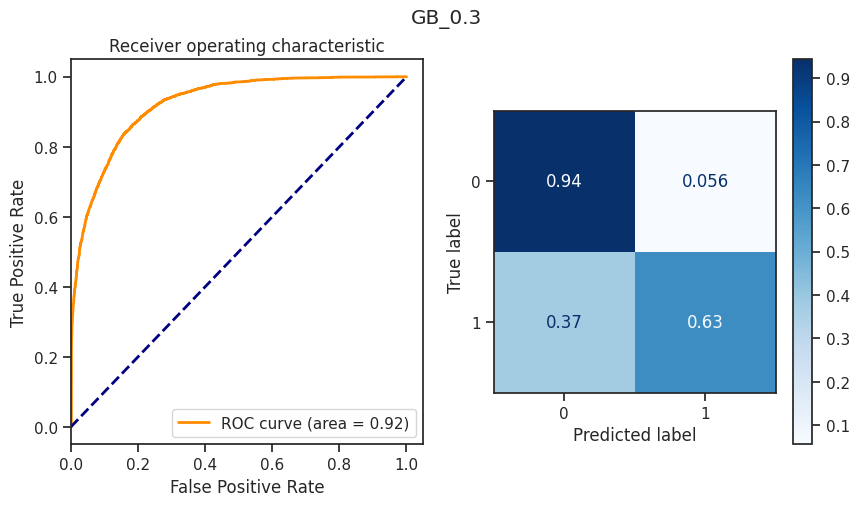

In [ ]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

## Формирование выводов о качестве построенных моделей на основе выбранных метрик.

### Решение задачи классификации

In [ ]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

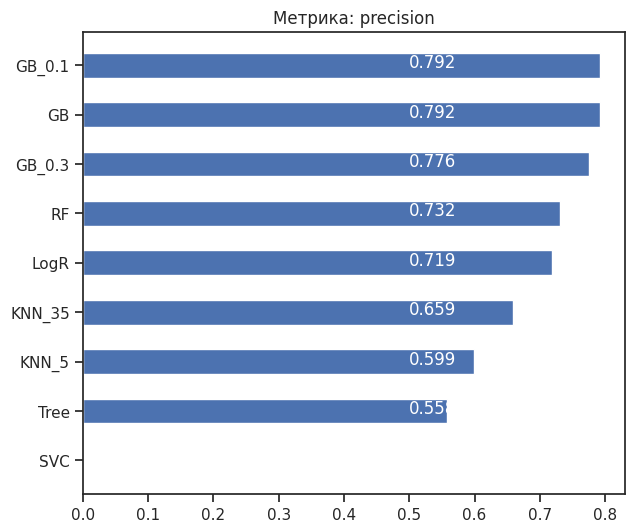

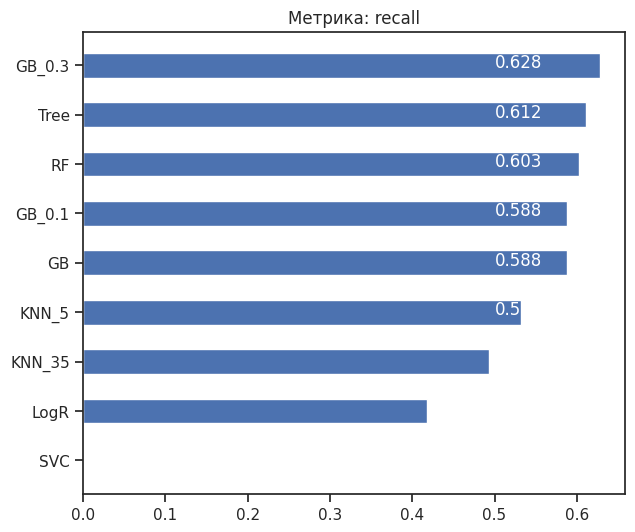

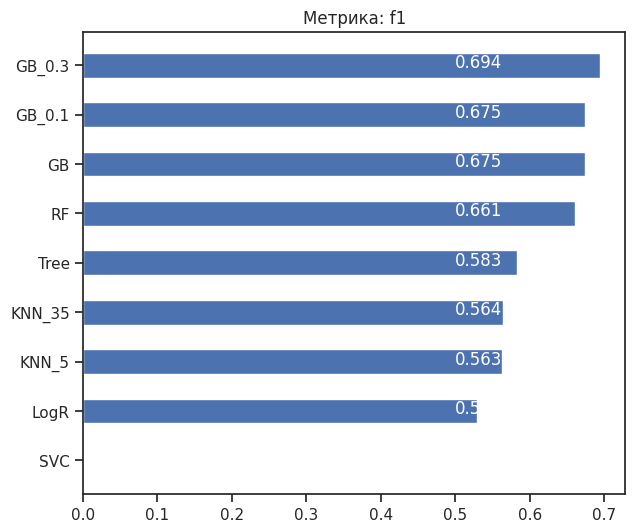

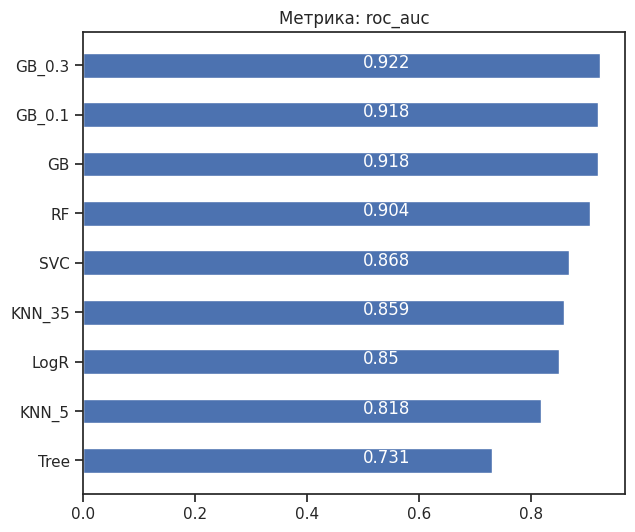

In [ ]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

In [ ]:
!git branch NIR_TMO

fatal: Not a valid object name: 'master'.


**Вывод: на основании трех метрик из четырех используемых, лучшей оказалась модель градиентного спуска c оптимальными параметрами.**